In [ ]:
from pathlib import Path
from health_lifestyle_diabetes.infrastructure.data_sources.csv_dataset_repository import CSVDatasetRepository
from health_lifestyle_diabetes.infrastructure.logger.loguru_logger import LoguruLogger
from health_lifestyle_diabetes.application.use_cases.load_dataset_use_case import LoadDatasetUseCase
from health_lifestyle_diabetes.infrastructure.utils.config_loader import YamlConfigLoader
from health_lifestyle_diabetes.infrastructure.utils.paths import get_repository_root
from health_lifestyle_diabetes.infrastructure.logger.config import configure_logging
from health_lifestyle_diabetes.infrastructure.training_diagnostics.diagnostics import (
    BoostingTrainingDiagnostics,
)
from health_lifestyle_diabetes.infrastructure.tracking.run_name_generator import generate_run_name
from health_lifestyle_diabetes.infrastructure.splitters.sklearn_splitter import SklearnDatasetSplitter
from health_lifestyle_diabetes.application.use_cases.split_dataset_use_case import SplitDatasetUseCase
from health_lifestyle_diabetes.infrastructure.features_selections import features_selection as fs
from health_lifestyle_diabetes.infrastructure.model_trainers.lightgbm_trainer import (
    LightGBMTrainer,
)
from health_lifestyle_diabetes.infrastructure.model_trainers.catboost_trainer import (
    CatBoostTrainer,
)

from health_lifestyle_diabetes.infrastructure.model_trainers.xgboost_trainer import (
    XGBoostTrainer,
)



# Configure logging
configure_logging(env="dev")

# Get repository root path
root = get_repository_root()

# Load configuration
config_loader = YamlConfigLoader()
paths = config_loader.load_config(f"{root}/configs/paths.yaml")
train_paths = get_repository_root() / Path(paths["data"]["input"]["raw_dataset"])

# Injection de dépendance comme en entreprise
repository = CSVDatasetRepository(source_path=train_paths, logger=LoguruLogger())
load_uc = LoadDatasetUseCase(repository=repository, logger=LoguruLogger())

# Exécution
dataset = load_uc.execute()

display(dataset.head()) # Affiche les 5 premières lignes pour validation.
print(f"le dataset chargé a {dataset.shape[0]} lignes et {dataset.shape[1]} colonnes")

2025-12-30 20:23:50 | INFO     | config.py:67 | configure_logging() | Loguru configuré avec succès (mode: dev) | {'env': 'dev'}
2025-12-30 20:23:50 | INFO     | load_dataset_use_case.py:18 | execute() | Démarrage du chargement du dataset... | {}
2025-12-30 20:23:50 | INFO     | csv_dataset_repository.py:54 | load_dataset() | Chargement du dataset depuis : /Users/surelmanda/Downloads/ml-projects/Clean-Architecture-MLops/health_lifestyle_diabetes/data/raw/diabetes_health_indicators.csv | {}
2025-12-30 20:23:50 | INFO     | csv_dataset_repository.py:61 | load_dataset() | Dataset chargé avec succès (97297 lignes, 31 colonnes). | {}
2025-12-30 20:23:50 | INFO     | load_dataset_use_case.py:20 | execute() | Dataset chargé : 97297 lignes, 31 colonnes. | {}


,Age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,52,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


le dataset chargé a 97297 lignes et 31 colonnes


In [2]:
# 1) Load config
cfg = YamlConfigLoader().load_config(f"{get_repository_root()}/configs/splitter.yaml")["splitter"]

# 2) Logger + DI (Dépendency Injection)
logger = LoguruLogger()
splitter = SklearnDatasetSplitter(
    train_size=cfg["train_size"],
    target_column=cfg["target_column"],
    random_state=cfg["random_state"],
    logger=logger,
)

# 3) Use Case orchestré
use_case = SplitDatasetUseCase(splitter=splitter, logger=logger)
train_df, test_df = use_case.execute(df=dataset)

# 4) Vérification
#print(train_df.shape, valid_df.shape)
#train_df.head()

2025-12-30 20:23:50 | DEBUG    | sklearn_splitter.py:37 | __init__() | SklearnDatasetSplitter initialized | {}
2025-12-30 20:23:50 | INFO     | split_dataset_use_case.py:41 | execute() | Démarrage du split dataset... | {}
2025-12-30 20:23:50 | INFO     | sklearn_splitter.py:42 | split() | Starting dataset split | {}
2025-12-30 20:23:51 | INFO     | sklearn_splitter.py:57 | split() | Split done | train=(82702, 31) | test=(14595, 31) | {}
2025-12-30 20:23:51 | INFO     | split_dataset_use_case.py:45 | execute() | Split terminé : train=(82702, 31), test=(14595, 31) | {}
2025-12-30 20:23:51 | INFO     | split_dataset_use_case.py:48 | execute() | Sauvegarde des datasets splittés... | {}
2025-12-30 20:23:51 | INFO     | split_dataset_use_case.py:52 | execute() | Datasets sauvegardés avec succès. | {}


In [3]:
## 1. Importations des couches Application et Infrastructure
from health_lifestyle_diabetes.infrastructure.feature_engineering.pipeline_feature_engineering import FeatureEngineeringPipeline
from health_lifestyle_diabetes.application.use_cases.build_features_use_case import BuildFeaturesUseCase
from health_lifestyle_diabetes.infrastructure.logger.loguru_logger import LoguruLogger

## 2. Initialisation du pipeline de preprocessing et du cas d'utilisation
pipeline = FeatureEngineeringPipeline(logger=LoguruLogger())
build_features_uc = BuildFeaturesUseCase(pipeline=pipeline)
# 3. Transformation des données d'entraînement
# Exécution de la transformation des données brutes en vecteurs de caractéristiques
train_enriche_df = build_features_uc.execute(data=train_df)

test_enriche_df = build_features_uc.execute(data=test_df)

2025-12-30 20:23:51 | INFO     | pipeline_feature_engineering.py:82 | transform() | Démarrage du pipeline complet de Feature Engineering... | {}


2025-12-30 20:23:51 | INFO     | exclusion.py:36 | drop_leakage_columns() | Vérification des colonnes à risque de data leakage... | {}
2025-12-30 20:23:51 | INFO     | exclusion.py:40 | drop_leakage_columns() | Suppression des colonnes à risque de leakage : ['diabetes_risk_score', 'diabetes_stage'] | {}
2025-12-30 20:23:51 | INFO     | base_preprocessing.py:25 | clean_categorical_variables() | Nettoyage des variables catégorielles... | {}
2025-12-30 20:23:51 | INFO     | base_preprocessing.py:32 | clean_categorical_variables() | Libellés uniformisés avec succès. | {}
2025-12-30 20:23:51 | INFO     | demographics_features.py:82 | transform() | Création des variables démographiques... | {}
2025-12-30 20:23:51 | INFO     | demographics_features.py:68 | _create_age_group() | Utilisation du découpage d'âge en 3 catégories. | {}
2025-12-30 20:23:51 | INFO     | demographics_features.py:111 | transform() | Variables démographiques complétées. | {}
2025-12-30 20:23:51 | INFO     | medical_feat

In [4]:
use_case = SplitDatasetUseCase(splitter=splitter, logger=logger,save=False)
train_df_enriched, valid_df_enriched  = use_case.execute(df=train_enriche_df)
print("Dataset successfully split into training and validation sets.")
print(f"Train set shape: {train_df_enriched.shape}")
print(f"Validation set shape: {valid_df_enriched.shape}")

2025-12-30 20:23:52 | INFO     | split_dataset_use_case.py:41 | execute() | Démarrage du split dataset... | {}
2025-12-30 20:23:52 | INFO     | sklearn_splitter.py:42 | split() | Starting dataset split | {}
Dataset successfully split into training and validation sets.2025-12-30 20:23:52 | INFO     | sklearn_splitter.py:57 | split() | Split done | train=(70296, 52) | test=(12406, 52) | {}

Train set shape: (70296, 52)
Validation set shape: (12406, 52)
2025-12-30 20:23:52 | INFO     | split_dataset_use_case.py:45 | execute() | Split terminé : train=(70296, 52), test=(12406, 52) | {}


In [5]:
# Préparation des matrices de caractéristiques (X) et des vecteurs cibles (y)

# Pour l'entraînement
X_train = train_df_enriched[fs.SELECTED_FEATURES]
y_train = train_df_enriched[fs.TARGET_COLUMN]

# Pour le test
X_test = test_enriche_df[fs.SELECTED_FEATURES]
y_test = test_enriche_df[fs.TARGET_COLUMN]

# Pour la validation
X_valid = valid_df_enriched[fs.SELECTED_FEATURES]
y_valid = valid_df_enriched[fs.TARGET_COLUMN]

# Affichage des dimensions des matrices et vecteurs
print("Étape 5.3 : Dimensions finales des matrices de caractéristiques (X) :")
print(f"- X_train (Features d'entraînement) : {X_train.shape[0]} lignes, {X_train.shape[1]} colonnes")
print(f"- X_test (Features de test)         : {X_test.shape[0]} lignes, {X_test.shape[1]} colonnes")
print(f"- X_valid (Features de validation)  : {X_valid.shape[0]} lignes, {X_valid.shape[1]} colonnes")

print("\nÉtape 5.4 : Vérification des vecteurs cibles (y) :")
print(f"- y_train : {y_train.shape[0]} lignes")
print(f"- y_test : {y_test.shape[0]} lignes")
print(f"- y_valid : {y_valid.shape[0]} lignes")

Étape 5.3 : Dimensions finales des matrices de caractéristiques (X) :
- X_train (Features d'entraînement) : 70296 lignes, 5 colonnes
- X_test (Features de test)         : 14595 lignes, 5 colonnes
- X_valid (Features de validation)  : 12406 lignes, 5 colonnes

Étape 5.4 : Vérification des vecteurs cibles (y) :
- y_train : 70296 lignes
- y_test : 14595 lignes
- y_valid : 12406 lignes


2025-12-30 20:23:52 | INFO     | catboost_trainer.py:38 | __init__() | CatBoostTrainer initialisé avec les paramètres fournis. | {}
2025-12-30 20:23:52 | INFO     | catboost_trainer.py:111 | train() | Entraînement CatBoost | train_shape=(70296, 5) | valid_shape=(12406, 5) | {}
2025-12-30 20:23:52 | INFO     | catboost_trainer.py:127 | train() | Détection automatique des variables catégorielles : ['glucose_status'] | {}
2025-12-30 20:23:52 | INFO     | catboost_trainer.py:137 | train() | Démarrage de l'entraînement CatBoost. | {}
0:	learn: 0.4916661	test: 0.4921723	best: 0.4921723 (0)	total: 79ms	remaining: 1m 58s
100:	learn: 0.2103893	test: 0.2158870	best: 0.2156872 (50)	total: 1.69s	remaining: 23.4s
200:	learn: 0.2074451	test: 0.2164423	best: 0.2156872 (50)	total: 3.47s	remaining: 22.4s
300:	learn: 0.2039684	test: 0.2168997	best: 0.2156872 (50)	total: 5.18s	remaining: 20.7s
400:	learn: 0.2010019	test: 0.2175322	best: 0.2156872 (50)	total: 6.93s	remaining: 19s
500:	learn: 0.1985365	tes

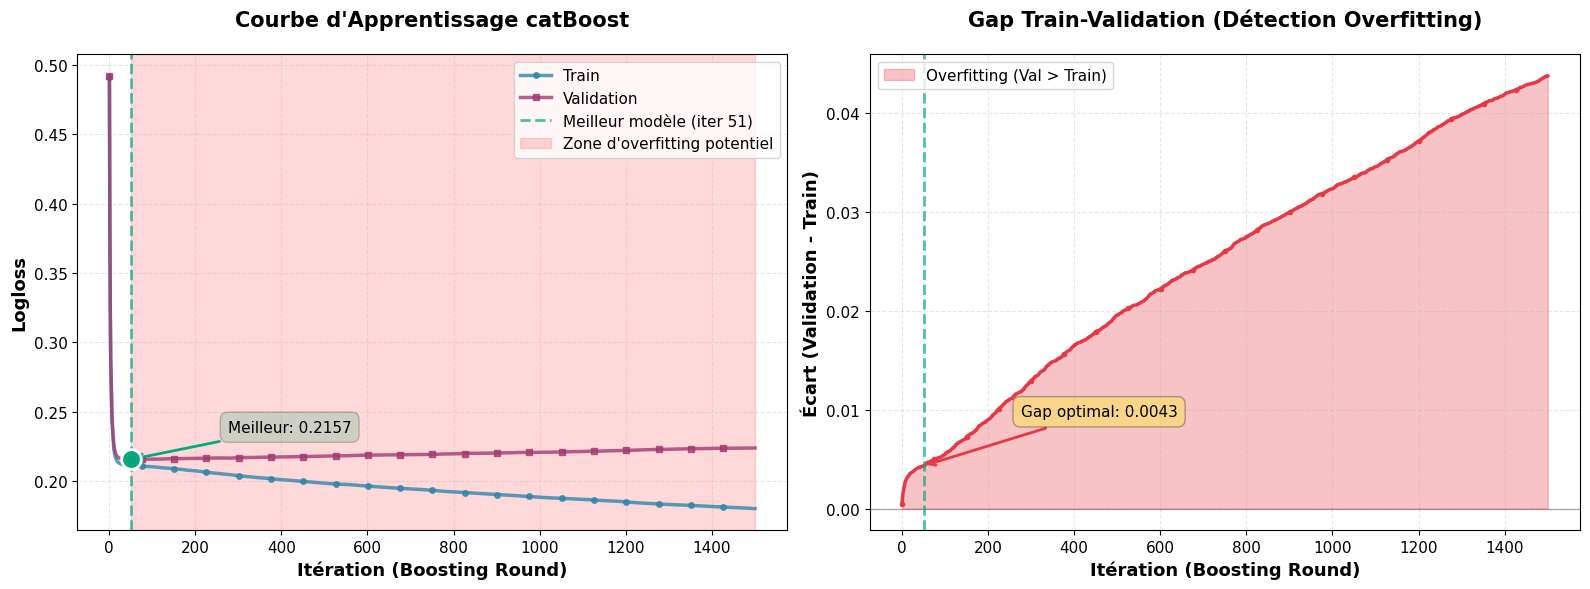

In [6]:
# ============================================================
# Paramètres CatBoost
# ============================================================
catboost_params = {
    "iterations": 1500,
    "learning_rate": 0.1,
    "depth": 6,
    "loss_function": "Logloss",
    "eval_metric": "Logloss",  #"AUC"
    "verbose": 100,   # ← test du verbose
}

# ============================================================
# Entraînement
# ============================================================
trainer = CatBoostTrainer(params=catboost_params,logger = LoguruLogger())

model = trainer.train(
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)

print("Modèle entraîné :", model)


# ============================================================
# Plot des diagnostics d'entraînement
# ============================================================
EXPERIMENT_NAME = "health_lifestyle_diabetes"
RUN_NAME = generate_run_name(prefix="CATB")
MODEL_NAME = "catBoost"

diagnostics = BoostingTrainingDiagnostics(
    model=model,
    model_name=MODEL_NAME,
    run_name=RUN_NAME,
)

diagnostics.run(
    backend="matplotlib",  # "matplotlib" ou "plotly"
    save_figure=True,
)


2025-12-30 20:26:35 | INFO     | confusion_matrix_service.py:33 | run() | Exécution CM avec normalisation='pred' | {}
2025-12-30 20:26:35 | INFO     | confusion_matrix_matplotlib_adapter.py:57 | plot() | [ADAPTER] CM | normalization=pred | {}


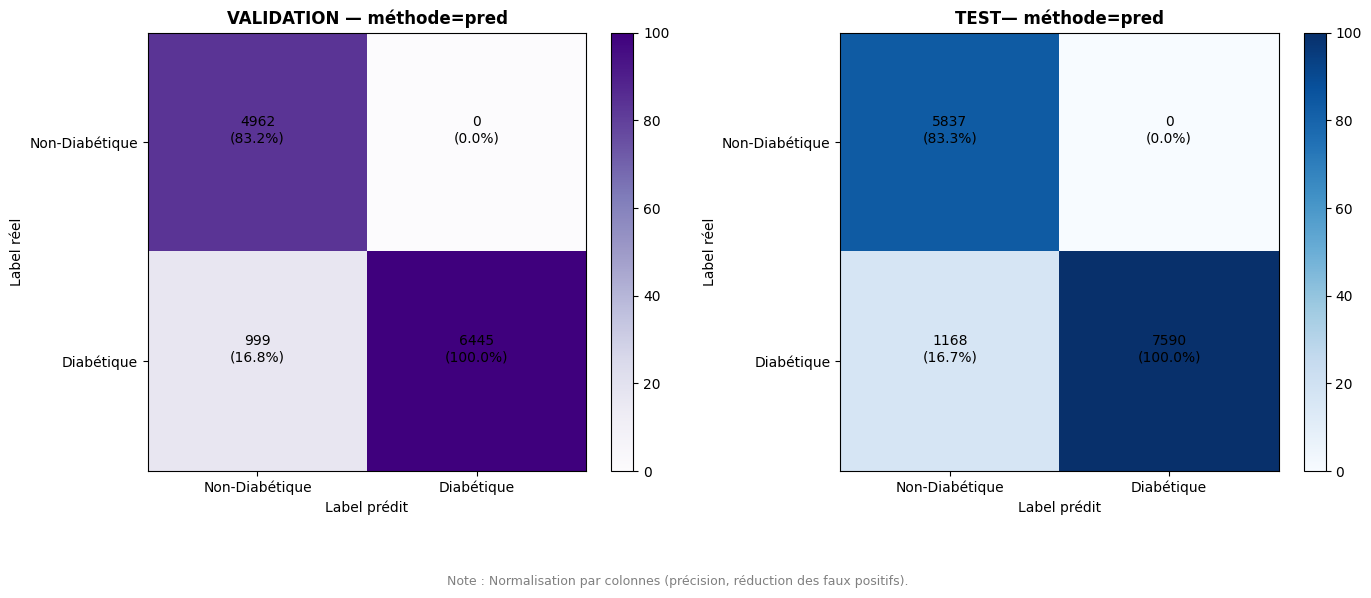

2025-12-30 20:26:35 | INFO     | confusion_matrix_matplotlib_adapter.py:70 | plot() | [ADAPTER] Sauvegardé -> /Users/surelmanda/Downloads/ml-projects/Clean-Architecture-MLops/health_lifestyle_diabetes/reports/cm/CATB_2025-12-30_20h26m35s_cm_pred.png | {}
2025-12-30 20:26:35 | INFO     | confusion_matrix_service.py:46 | run() | Matrice(s) de confusion générée(s). | {}


In [8]:
from health_lifestyle_diabetes.application.services.confusion_matrix_service import ConfusionMatrixService
from health_lifestyle_diabetes.infrastructure.visualization.confusion_matrix_matplotlib_adapter import ConfusionMatrixMatplotlibAdapter
from health_lifestyle_diabetes.infrastructure.logger.loguru_logger import LoguruLogger
from health_lifestyle_diabetes.domain.entities.confusion_matrix_config import ConfusionMatrixConfig

logger = LoguruLogger()

service = ConfusionMatrixService(
    plotter=ConfusionMatrixMatplotlibAdapter(logger),
    logger=logger
)

#normalization="row"   # Recall (dépistage)
#normalization="diag"  # analyse des erreurs critiques
normalization="pred"  # recommandé pour médecine
config = ConfusionMatrixConfig(normalization=normalization)

service.run(
    model=model,
    X_test=X_test,
    y_test=y_test,
    X_valid=X_valid,
    y_valid=y_valid,
    config=config,
    run_name=generate_run_name(prefix="CATB"),
    save=True
)

In [8]:
print(len(X_train), len(X_valid))

48 9


2025-12-30 11:19:36 | INFO     | xgboost_trainer.py:31 | __init__() | XGBoostTrainer initialisé avec les paramètres fournis. | {}
2025-12-30 11:19:36 | INFO     | xgboost_trainer.py:91 | train() | XGBoost - Entraînement | train=(501, 5), valid=(89, 5) | {}
2025-12-30 11:19:36 | DEBUG    | xgboost_trainer.py:95 | train() | XGBoost - Hyperparamètres: {'n_estimators': 1500, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42, 'eval_metric': 'logloss'} | {}
2025-12-30 11:19:36 | INFO     | xgboost_trainer.py:101 | train() | XGBoost - Variables catégorielles détectées : ['glucose_status'] | {}
2025-12-30 11:19:36 | INFO     | xgboost_trainer.py:114 | train() | XGBoost - Démarrage de l'entraînement... | {}
[0]	validation_0-logloss:0.66616	validation_1-logloss:0.66811
[1]	validation_0-logloss:0.65892	validation_1-logloss:0.66139
[2]	validation_0-logloss:0.65160	validation_1-logloss:0.65446
[3]	validation_0-logloss:0.64452	validation_1-logloss:0

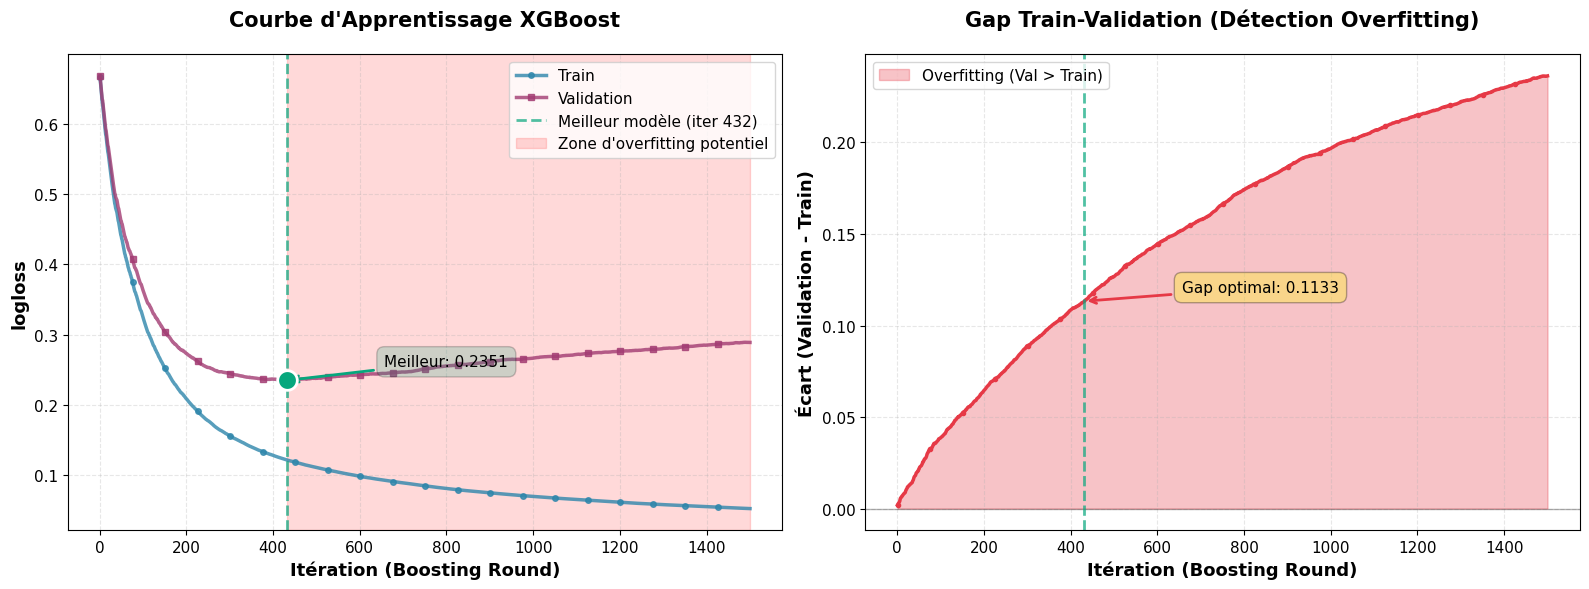

In [7]:
# ============================================================
# Paramètres XGBoost
# ============================================================
xgb_params = {
    "n_estimators": 1500,
    "max_depth": 6,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "eval_metric":"logloss",   # métrique standard binaire
    #"verbose": False,
    #"early_stopping_rounds": 50,  # géré dans le trainer si valid set
}


# ============================================================
# Entraînement
# ============================================================
trainer = XGBoostTrainer(
    params=xgb_params,
    logger=LoguruLogger()
)

model = trainer.train(
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)

print("Modèle XGBoost entraîné :", model)

# ============================================================
# Plot des diagnostics d'entraînement
# ============================================================
EXPERIMENT_NAME = "health_lifestyle_diabetes"
RUN_NAME = generate_run_name(prefix="XGB")
MODEL_NAME = "XGBoost"

diagnostics = BoostingTrainingDiagnostics(
    model=model,
    model_name=MODEL_NAME,
    run_name=RUN_NAME,
)

diagnostics.run(
    backend="matplotlib",  # "matplotlib" ou "plotly"
    save_figure=True,
)


2025-12-30 11:19:41 | INFO     | lightgbm_trainer.py:20 | __init__() | Initialisation LightGBMTrainer terminée. | {}
2025-12-30 11:19:41 | DEBUG    | lightgbm_trainer.py:30 | train() | Début de la méthode train() | {}
2025-12-30 11:19:41 | INFO     | lightgbm_trainer.py:33 | train() | Validation des données... | {}
2025-12-30 11:19:41 | INFO     | lightgbm_trainer.py:42 | train() | Taille train: (501, 5) | {}
2025-12-30 11:19:41 | INFO     | lightgbm_trainer.py:43 | train() | Taille valid: (89, 5) | {}
2025-12-30 11:19:41 | INFO     | lightgbm_trainer.py:51 | train() | Détection et conversion des colonnes catégorielles... | {}
2025-12-30 11:19:41 | DEBUG    | lightgbm_trainer.py:55 | train() | Colonnes catégorielles détectées: ['hba1c', 'glucose_fasting'] | {}
2025-12-30 11:19:41 | INFO     | lightgbm_trainer.py:58 | train() | Initialisation du modèle LightGBM... | {}
2025-12-30 11:19:41 | DEBUG    | lightgbm_trainer.py:59 | train() | Hyperparamètres LightGBM: {'n_estimators': 1500, 'l

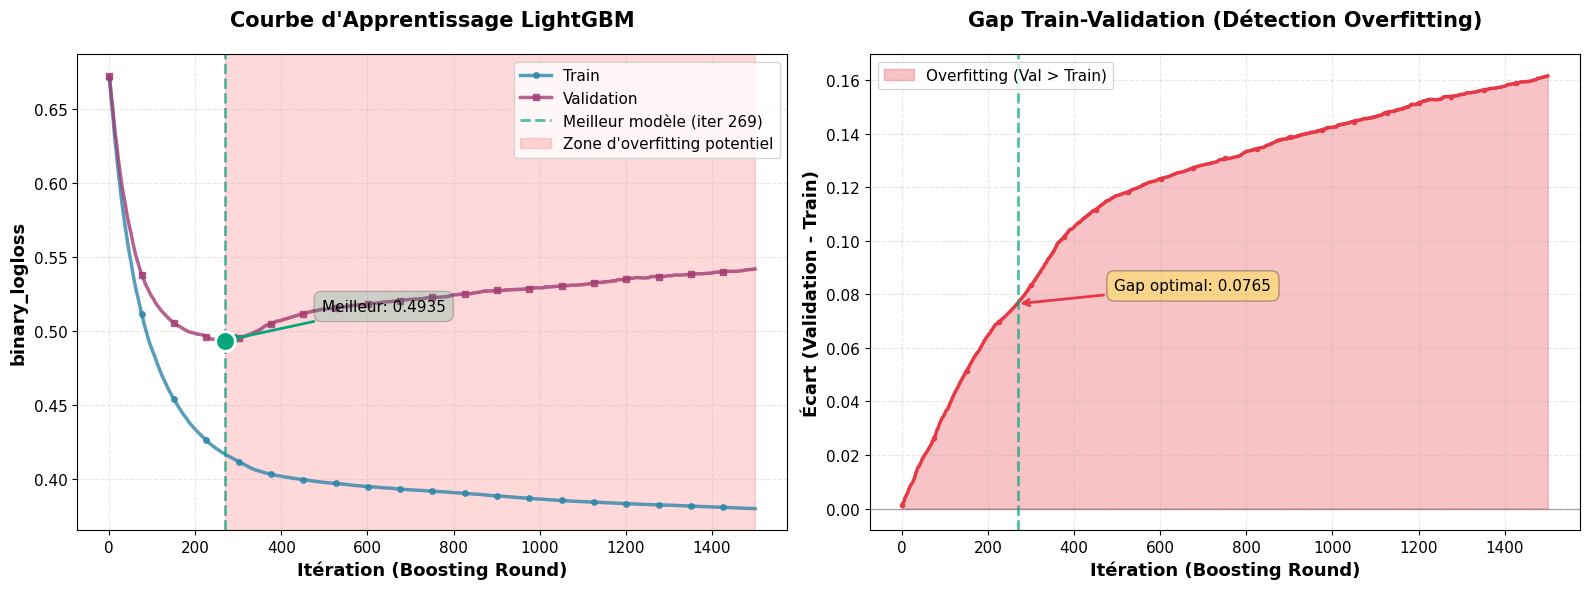

In [8]:
# ============================================================
# Paramètres LightGBM
# ============================================================
lgbm_params = {
    "n_estimators": 1500,
    "learning_rate": 0.01,
    "max_depth": 4,
    "num_leaves": 31,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "metric": "logloss",          # métrique suivie pendant l'entraînement
    #"early_stopping_rounds": 50,  # géré si un jeu de validation est fourni
    "verbosity": -1,  # masque tous les logs
}


# ============================================================
# Entraînement
# ============================================================
trainer = LightGBMTrainer(
    params=lgbm_params,
    logger=LoguruLogger()
)

model = trainer.train(
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)

print("Modèle LightGBM entraîné :", model)

# ============================================================
# Plot des diagnostics d'entraînement
# ============================================================
EXPERIMENT_NAME = "health_lifestyle_diabetes"
RUN_NAME = generate_run_name(prefix="LGBM")
MODEL_NAME = "LightGBM"

diagnostics = BoostingTrainingDiagnostics(
    model=model,
    model_name=MODEL_NAME,
    run_name=RUN_NAME,
)

diagnostics.run(
    backend="matplotlib",      # "matplotlib" ou "plotly"
    save_figure=True,
)

# Apply Experiments to MLFLOW

In [ ]:
# ============================================================
# 0) Imports - Dépendances Clean Architecture
# ============================================================
from health_lifestyle_diabetes.infrastructure.logger.config import configure_logging
from health_lifestyle_diabetes.infrastructure.logger.loguru_logger import LoguruLogger
from health_lifestyle_diabetes.infrastructure.tracking.mlflow_tracker import MLflowExperimentTracker
from health_lifestyle_diabetes.application.services.experiment_tracking_service import ExperimentTrackingService
from health_lifestyle_diabetes.infrastructure.tracking.run_name_generator import generate_run_name
from health_lifestyle_diabetes.infrastructure.model_trainers.catboost_trainer import (
    CatBoostTrainer,
)
from health_lifestyle_diabetes.infrastructure.training_diagnostics.diagnostics import (
    BoostingTrainingDiagnostics,
)

# ============================================================
# 1.) Config log + injection dépendances
# ============================================================
configure_logging(env="dev")

logger = LoguruLogger()
tracker = MLflowExperimentTracker(logger=logger)
tracking_service = ExperimentTrackingService(tracker=tracker, logger=logger)

# ============================================================
# 2.) Démarrer une expérience CatBoost dans MLflow
# ============================================================
EXPERIMENT_NAME = "health_lifestyle_diabetes"
RUN_NAME = generate_run_name(prefix="CATB")
MODEL_NAME = "CatBoost"
print(f"Starting experiment '{EXPERIMENT_NAME}' with run name '{MODEL_NAME}'")


tracking_service.start_experiment(
    experiment_name=EXPERIMENT_NAME,
    run_name=RUN_NAME
)

# ============================================================
# 4) Définition du modèle + log des paramètres
# ============================================================
# =========================
# Paramètres CatBoost
# =========================
catboost_params = {
    "iterations": 1500,
    "learning_rate": 0.05,
    "depth": 6,
    "loss_function": "Logloss",
    "eval_metric": "Logloss",  #"AUC"
    "verbose": 100,   # ← test du verbose
}
# Tracking des paramètres sur l'expérience mlflow
tracking_service.log_training_context(model_name=MODEL_NAME, params=catboost_params)
# =========================
# Entraînement
# =========================
trainer = CatBoostTrainer(params=catboost_params,logger=logger)
model = trainer.train(
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)

print("Modèle entraîné :", model)


# ============================================================
# 5.) Plot des diagnostics d'entraînement
# ============================================================
diagnostics = BoostingTrainingDiagnostics(
    model=model,
    model_name=MODEL_NAME,
    run_name=RUN_NAME,
)

diagnostics.run(
    backend="matplotlib",  # "matplotlib" ou "plotly"
    save_figure=True,
)

# ============================================================
# 6.) Évaluation du modèle sur le jeu de validation
# ============================================================
from health_lifestyle_diabetes.infrastructure.metrics.sklearn_metrics_adapter import SklearnMetricsAdapter
from health_lifestyle_diabetes.application.services.evaluation_service import EvaluationService

# Probabilités prédites par ton modèle
y_proba = model.predict_proba(X_valid)[:, 1]
y_true = y_valid

# Injection de dépendances
metrics_adapter = SklearnMetricsAdapter()
evaluator = EvaluationService(metrics_adapter)

# Évaluation
results = evaluator.evaluate(y_true, y_proba, threshold=0.5)
extra = results.extra_metrics or {}
main = {k: extra[k] for k in ["accuracy", "precision", "recall", "f1", "auc_roc"] if k in extra}
plot_metrics_bar(main, "Métriques principales")

# Log evaluation metrics
tracking_service.log_evaluation(main)

# ============================================================
# 7.) Fin de l'expérience
# ============================================================
tracking_service.close()

print("\nExécution terminée. Vérifier MLflow UI.")

In [ ]:

from health_lifestyle_diabetes.infrastructure.visualization.confusion_matrix_plotter import ConfusionMatrixPlotter
from health_lifestyle_diabetes.infrastructure.logger.loguru_logger import LoguruLogger

RUN_NAME = generate_run_name(prefix="CATB")
plotter = ConfusionMatrixPlotter()

normalization="row"   # Recall (dépistage)
normalization="diag"  # analyse des erreurs critiques
normalization="pred"  # recommandé pour médecine

plotter.plot_confusion_matrices(
    model=model,
    X_test=X_valid,
    y_test=y_valid,
    X_valid=X_valid,
    y_valid=y_valid,
    normalization="pred",  #recommandé pour médecine
    save_figure=True,
    run_name=RUN_NAME,
)